# Mask Detection & Localization — Colab (Custom + TL)

## 1) Setup e imports

In [1]:
!pip -q uninstall -y albumentations albucore
!pip -q install albumentations==1.3.1 torchmetrics==1.4.0.post0 opencv-python-headless==4.10.0.84


import os, json, math, random, time, zipfile, io
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional
import copy

import numpy as np
import pandas as pd
from PIL import Image, ImageDraw

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from torchvision import transforms, models

from torchmetrics.classification import BinaryAccuracy, BinaryAUROC

import albumentations as A
from albumentations.pytorch import ToTensorV2

SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.9 MB/s eta 0:00:00
Device: cuda


## 2) GPU Tuning (cuDNN/TF32/AMP helpers)

In [ ]:
import torch

print(torch.__version__, getattr(torch.version, "cuda", "no-cuda"))

torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
try:
    torch.set_float32_matmul_precision("medium")
except Exception:
    pass


def free_vram():
    import gc

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("VRAM cleared.")

2.8.0+cu126 12.6


## 3) Datos — descomprimir y rutas

In [ ]:
# Ajusta a tu estructura. Si subes el ZIP a Colab, monta Drive o usa /content
BASE_DIR = Path(".")
DATA_ZIP = Path(
    "aa-iv-2025-ii-object-localization.zip"
)  # <- ajusta si el nombre cambia

if DATA_ZIP.exists():
    with zipfile.ZipFile(DATA_ZIP, "r") as zf:
        zf.extractall("./data_mask")
        print("ZIP extraído en ./data_mask")
else:
    print(" Sube el ZIP 'aa-iv-2025-ii-object-localization.zip' o ajusta la ruta.")


# Heurística: busca CSV y carpeta de imágenes
def find_first(patterns, root=Path("./data_mask")):
    for p in root.rglob("*"):
        if any(str(p).endswith(suf) for suf in patterns):
            return p
    return None


# Modify to prioritize train.csv for training
TRAIN_CSV_PATH = find_first(["train.csv"], root=Path("./data_mask")) or Path(
    "./data_mask/train.csv"
)
TEST_CSV_PATH = find_first(["test.csv"], root=Path("./data_mask")) or Path(
    "./data_mask/test.csv"
)
CSV_PATH = TRAIN_CSV_PATH  # Use train.csv for training

IMAGES_DIR = find_first(["images", "imgs", "train"]) or Path("./data_mask/images")

print("CSV:", CSV_PATH)
print("IMG DIR:", IMAGES_DIR)

assert CSV_PATH.exists(), f"No se encontró CSV en {CSV_PATH}"
assert IMAGES_DIR.exists(), f"No se encontró carpeta de imágenes en {IMAGES_DIR}"

df = pd.read_csv(CSV_PATH)
print("Head:\n", df.head())

ZIP extraído en ./data_mask
CSV: data_mask/train.csv
IMG DIR: data_mask/images
Head:
                                             filename    class  xmin  ymin  \
0  video_CDC-YOUTUBE_mp4-63_jpg.rf.2f4f64f6ef712f...  no-mask   315   249   
1  IMG_4860_mp4-36_jpg.rf.01a053cabddff2cdd19f04e...  no-mask   257   237   
2  IMG_1491_mp4-12_jpg.rf.9df64033aebef44b8bb9a6a...     mask   291   245   
3  IMG_4861_mp4-64_jpg.rf.74ab6d1da8a1fa9b8fbb576...  no-mask   231   229   
4  IMG_9950-1-_mp4-83_jpg.rf.74dca33810c23ba144d8...  no-mask   107   168   

   xmax  ymax  
0   468   374  
1   299   264  
2   582   449  
3   577   420  
4   515   469  


## 4) Configuración y mapeo de clases

In [ ]:
DEFAULT_COLS = {
    "filename": "filename",
    "xmin": "xmin",
    "ymin": "ymin",
    "xmax": "xmax",
    "ymax": "ymax",
    "class": "class",
}

# Ajusta a tus etiquetas reales (asegúrate de que df['class'] coincida)
# Si tienes 'with_mask'/'without_mask', añade esas claves aquí.
CLASS_TO_LABEL = {
    "mask": 1,
    "with_mask": 1,
    "con_mascarilla": 1,
    "tapabocas": 1,
    "no-mask": 0,
    "without_mask": 0,
    "sin_mascarilla": 0,
    "no_tapabocas": 0,
    "incorrect_mask": 0,
    "incorrect": 0,
}


@dataclass
class TrainConfig:
    img_size: int = 256
    batch_size: int = 32
    lr: float = 8e-4
    weight_decay: float = 1e-4
    epochs: int = 8
    feat_dim: int = 512
    base_ch: int = 32
    dropout: float = 0.2
    aug_strength: str = "medium"  # none|light|medium|strong
    use_albu: bool = True
    cls_loss_w: float = 1.0
    box_loss_w: float = 2.0
    beta_smoothl1: float = 1.0
    backbone_type: str = "custom"  # custom|resnet18|mobilenetv3
    # Early stopping
    es_patience: int = 4
    # TL
    freeze_backbone_epochs: int = 0
    monitor: str = "val_iou"  # "val_loss" | "val_iou" | "val_score"
    monitor_mode: str = "max"  # "min" para loss, "max" para iou/score
    alpha_score: float = 0.7  # si usas "val_score": score = alpha*IoU + (1-alpha)*ACC

## 5) Utilidades: IoU / GIoU / pérdidas

In [ ]:
def iou(boxA, boxB):
    # box tensor [4] en píxeles
    xA = torch.max(boxA[..., 0], boxB[..., 0])
    yA = torch.max(boxA[..., 1], boxB[..., 1])
    xB = torch.min(boxA[..., 2], boxB[..., 2])
    yB = torch.min(boxA[..., 3], boxB[..., 3])
    inter = (xB - xA).clamp(min=0) * (yB - yA).clamp(min=0)
    areaA = (boxA[..., 2] - boxA[..., 0]).clamp(min=0) * (
        boxA[..., 3] - boxA[..., 1]
    ).clamp(min=0)
    areaB = (boxB[..., 2] - boxB[..., 0]).clamp(min=0) * (
        boxB[..., 3] - boxB[..., 1]
    ).clamp(min=0)
    union = areaA + areaB - inter + 1e-7
    return inter / union


def box_area(b):
    return ((b[..., 2] - b[..., 0]).clamp(min=0)) * (
        (b[..., 3] - b[..., 1]).clamp(min=0)
    )


def giou(pred, target, eps=1e-7):
    # pred, target en xyxy normalizado [0,1]
    x1 = torch.max(pred[..., 0], target[..., 0])
    y1 = torch.max(pred[..., 1], target[..., 1])
    x2 = torch.min(pred[..., 2], target[..., 2])
    y2 = torch.min(pred[..., 3], target[..., 3])
    inter = (x2 - x1).clamp(min=0) * (y2 - y1).clamp(min=0)
    ap = box_area(pred)
    at = box_area(target)
    union = ap + at - inter + eps
    iou_val = inter / union

    ex1 = torch.min(pred[..., 0], target[..., 0])
    ey1 = torch.min(pred[..., 1], target[..., 1])
    ex2 = torch.max(pred[..., 2], target[..., 2])
    ey2 = torch.max(pred[..., 3], target[..., 3])
    area_c = (ex2 - ex1).clamp(min=0) * (ey2 - ey1).clamp(min=0) + eps
    return iou_val - (area_c - union) / area_c


def giou_loss(pred, tgt):
    return (1.0 - giou(pred, tgt)).mean()


def smooth_l1_loss(input, target, beta=1.0):
    # PyTorch already has smooth_l1_loss, pero dejamos control de beta
    return F.smooth_l1_loss(input, target, beta=beta)


def diou(pred, target, eps=1e-7):  # pred/target en xyxy normalizado [0,1]
    x1 = torch.max(pred[..., 0], target[..., 0])
    y1 = torch.max(pred[..., 1], target[..., 1])
    x2 = torch.min(pred[..., 2], target[..., 2])
    y2 = torch.min(pred[..., 3], target[..., 3])
    inter = (x2 - x1).clamp(min=0) * (y2 - y1).clamp(min=0)
    ap = box_area(pred)
    at = box_area(target)
    union = ap + at - inter + eps
    iou_val = inter / union

    # distancia de centros (penaliza cajas lejos aun con IoU moderado)
    pcx = (pred[..., 0] + pred[..., 2]) / 2
    pcy = (pred[..., 1] + pred[..., 3]) / 2
    tcx = (target[..., 0] + target[..., 2]) / 2
    tcy = (target[..., 1] + target[..., 3]) / 2
    center_dist2 = (pcx - tcx) ** 2 + (pcy - tcy) ** 2

    # diagonal del rectángulo envolvente
    ex1 = torch.min(pred[..., 0], target[..., 0])
    ey1 = torch.min(pred[..., 1], target[..., 1])
    ex2 = torch.max(pred[..., 2], target[..., 2])
    ey2 = torch.max(pred[..., 3], target[..., 3])
    cw = (ex2 - ex1).clamp(min=0)
    ch = (ey2 - ey1).clamp(min=0)
    c2 = cw * cw + ch * ch + eps

    return iou_val - center_dist2 / c2


def diou_loss(pred, tgt):
    return (1.0 - diou(pred, tgt)).mean()

## 6) Dataset — reescalado bbox → img_size y salida [0,1]

In [ ]:
class MaskDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        images_dir: Path,
        img_size: int = 256,
        train: bool = True,
        aug_strength: str = "medium",
        use_albu: bool = True,
        cols: Dict[str, str] = DEFAULT_COLS,
    ):
        self.df = df.reset_index(drop=True)
        self.images_dir = images_dir
        self.img_size = img_size
        self.train = train
        self.cols = cols
        self.aug_strength = aug_strength
        self.use_albu = use_albu

        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]

        if self.use_albu:
            if self.aug_strength == "light":
                tfs = [A.HorizontalFlip(p=0.5)]
            elif self.aug_strength == "medium":
                tfs = [
                    A.HorizontalFlip(p=0.5),
                    A.ShiftScaleRotate(
                        shift_limit=0.03,
                        scale_limit=0.1,
                        rotate_limit=8,
                        border_mode=0,
                        p=0.7,
                    ),
                    A.RandomBrightnessContrast(0.15, 0.15, p=0.5),
                ]
            else:
                tfs = [
                    A.HorizontalFlip(p=0.5),
                    A.ShiftScaleRotate(
                        shift_limit=0.05,
                        scale_limit=0.15,
                        rotate_limit=12,
                        border_mode=0,
                        p=0.9,
                    ),
                    A.RandomBrightnessContrast(0.25, 0.25, p=0.7),
                    A.ImageCompression(quality_lower=70, quality_upper=100, p=0.3),
                ]
            self.albu_train = A.Compose(
                tfs + [A.Normalize(mean=self.mean, std=self.std), ToTensorV2()],
                bbox_params=A.BboxParams(
                    format="pascal_voc", label_fields=["labels"], min_visibility=0.3
                ),
            )
            self.albu_valid = A.Compose(
                [A.Normalize(mean=self.mean, std=self.std), ToTensorV2()],
                bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"]),
            )

    def _load_image(self, filename: str) -> Image.Image:
        path = self.images_dir / filename
        return Image.open(path).convert("RGB")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fname = row[self.cols["filename"]]
        x1 = float(row[self.cols["xmin"]])
        y1 = float(row[self.cols["ymin"]])
        x2 = float(row[self.cols["xmax"]])
        y2 = float(row[self.cols["ymax"]])
        cls_name = str(row[self.cols["class"]]).strip().lower()
        label = CLASS_TO_LABEL.get(cls_name, 0)

        img = self._load_image(fname)
        w0, h0 = img.size

        # resize imagen
        img = img.resize((self.img_size, self.img_size), Image.BILINEAR)
        img_np = np.array(img)

        # reescalar bbox al nuevo tamaño
        sx = self.img_size / float(w0)
        sy = self.img_size / float(h0)
        bx = [x1 * sx, y1 * sy, x2 * sx, y2 * sy]
        bx[0] = max(0.0, min(self.img_size - 1, bx[0]))
        bx[1] = max(0.0, min(self.img_size - 1, bx[1]))
        bx[2] = max(0.0, min(self.img_size - 1, bx[2]))
        bx[3] = max(0.0, min(self.img_size - 1, bx[3]))

        if self.use_albu:
            comp = self.albu_train if self.train else self.albu_valid
            out = comp(image=img_np, bboxes=[bx], labels=[label])
            img_t = out["image"]
            bxs = out["bboxes"]
            box_px = np.array(bx if len(bxs) == 0 else bxs[0], dtype=np.float32)
        else:
            img_t = transforms.ToTensor()(Image.fromarray(img_np))
            img_t = transforms.Normalize(self.mean, self.std)(img_t)
            box_px = np.array(bx, dtype=np.float32)

        s = float(self.img_size)
        target_box = torch.tensor(
            [box_px[0] / s, box_px[1] / s, box_px[2] / s, box_px[3] / s],
            dtype=torch.float32,
        )
        target_cls = torch.tensor([float(label)], dtype=torch.float32)
        return img_t, target_box, target_cls, fname

## 7) Backbones — Custom y preentrenados

In [ ]:
class SimpleBackbone(nn.Module):
    def __init__(self, base_ch=32, feat_dim=512):
        super().__init__()
        c = base_ch
        self.body = nn.Sequential(
            nn.Conv2d(3, c, 3, 2, 1),
            nn.BatchNorm2d(c),
            nn.ReLU(inplace=True),
            nn.Conv2d(c, c, 3, 1, 1),
            nn.BatchNorm2d(c),
            nn.ReLU(inplace=True),
            nn.Conv2d(c, 2 * c, 3, 2, 1),
            nn.BatchNorm2d(2 * c),
            nn.ReLU(inplace=True),
            nn.Conv2d(2 * c, 2 * c, 3, 1, 1),
            nn.BatchNorm2d(2 * c),
            nn.ReLU(inplace=True),
            nn.Conv2d(2 * c, 4 * c, 3, 2, 1),
            nn.BatchNorm2d(4 * c),
            nn.ReLU(inplace=True),
            nn.Conv2d(4 * c, 4 * c, 3, 1, 1),
            nn.BatchNorm2d(4 * c),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
        )
        self.proj = nn.Linear(4 * c, feat_dim)

    def forward(self, x):
        x = self.body(x).flatten(1)
        return self.proj(x)


def make_resnet18_backbone(feat_dim=512, pretrained=True):
    m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
    m.fc = nn.Identity()
    return nn.Sequential(
        m,
        nn.Flatten(),
        nn.Linear(512, feat_dim),
    )


# New function for ONNX export compatibility
def make_resnet18_backbone_onnx(
    img_size=256, feat_dim=512, pretrained=False
):  # pretrained=False since we load weights
    m = models.resnet18(weights=None)  # Always load weights manually
    # Replace AdaptiveAvgPool2d with AvgPool2d
    # ResNet18 downsamples the input by 32 (2*2*2*1*1*2). For 256x256 input,
    # the feature map size before pooling is 256/32 = 8.
    pool_size = (
        img_size // 32
    )  # Calculate pool size based on input size and model downsampling
    m.avgpool = nn.AvgPool2d(kernel_size=pool_size, stride=1)
    m.fc = nn.Identity()
    return nn.Sequential(
        m,
        nn.Flatten(),
        nn.Linear(512, feat_dim),
    )


def make_mobilenet_v3_small_backbone(feat_dim=512, pretrained=True):
    m = models.mobilenet_v3_small(
        weights=models.MobileNet_V3_Small_Weights.DEFAULT if pretrained else None
    )
    m.classifier = nn.Identity()
    feat_in = 576  # mobilenetv3_small last conv
    return nn.Sequential(
        m,
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(feat_in, feat_dim),
    )

## 8) Modelo TwoHeadNet (cx,cy,w,h → xyxy en [0,1])

In [ ]:
class TwoHeadNet(nn.Module):
    def __init__(
        self,
        backbone: nn.Module,
        feat_dim: int = 512,
        dropout: float = 0.2,
        min_wh: float = 1 / 64,
    ):
        super().__init__()
        self.backbone = backbone
        self.cls_head = nn.Sequential(
            nn.Linear(feat_dim, 256), nn.ReLU(), nn.Dropout(dropout), nn.Linear(256, 1)
        )
        self.box_head = nn.Sequential(
            nn.Linear(feat_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 4),  # cx, cy, w, h
        )
        self.min_wh = min_wh

    def forward(self, x):
        feats = self.backbone(x)
        logits = self.cls_head(feats)
        raw = self.box_head(feats)
        cxcy = torch.sigmoid(raw[:, :2])
        wh = F.softplus(raw[:, 2:]) + self.min_wh
        wh = torch.clamp(wh, max=1.0)
        x1y1 = cxcy - wh / 2
        x2y2 = cxcy + wh / 2
        x1 = torch.clamp(torch.minimum(x1y1[:, 0], x2y2[:, 0]), 0.0, 1.0)
        y1 = torch.clamp(torch.minimum(x1y1[:, 1], x2y2[:, 1]), 0.0, 1.0)
        x2 = torch.clamp(torch.maximum(x1y1[:, 0], x2y2[:, 0]), 0.0, 1.0)
        y2 = torch.clamp(torch.maximum(x1y1[:, 1], x2y2[:, 1]), 0.0, 1.0)
        box = torch.stack([x1, y1, x2, y2], dim=1)
        return logits.squeeze(1), box

## 9) Trainer unificado (AMP, SmoothL1+GIoU, early stopping, TL freeze)

In [ ]:
from torch.amp import autocast, GradScaler


class Trainer:
    def __init__(self, df: pd.DataFrame, cfg: TrainConfig):
        self.cfg = cfg

        # ----- pos_weight con cap para desbalance -----
        self.pos_weight = None
        if DEFAULT_COLS["class"] in df.columns:
            counts = (
                df[DEFAULT_COLS["class"]].str.lower().map(CLASS_TO_LABEL).value_counts()
            )
            pos = float(counts.get(1, 1.0))
            neg = float(counts.get(0, 1.0))
            cap = 5.0
            self.pos_weight = torch.tensor(
                [min(cap, max(1.0, neg / max(1.0, pos)))], device=DEVICE
            )
        else:
            print(
                "Warning: 'class' column not found in DataFrame. Skipping pos_weight calculation."
            )

        # ----- split train/valid -----
        n = len(df)
        n_train = int(n * 0.85)
        df_shuf = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)
        self.df_train = df_shuf.iloc[:n_train]
        self.df_valid = df_shuf.iloc[n_train:]

        # ----- datasets / dataloaders -----
        self.ds_train = MaskDataset(
            self.df_train,
            IMAGES_DIR,
            img_size=cfg.img_size,
            train=True,
            aug_strength=cfg.aug_strength,
            use_albu=getattr(cfg, "use_albu", True),
        )
        self.ds_valid = MaskDataset(
            self.df_valid,
            IMAGES_DIR,
            img_size=cfg.img_size,
            train=False,
            aug_strength="none",
            use_albu=False,
        )

        num_workers = min(4, os.cpu_count() or 2)
        self.dl_train = DataLoader(
            self.ds_train,
            batch_size=cfg.batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=(DEVICE == "cuda"),
            persistent_workers=(num_workers > 0),
            prefetch_factor=2,
        )
        self.dl_valid = DataLoader(
            self.ds_valid,
            batch_size=cfg.batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=(DEVICE == "cuda"),
            persistent_workers=(num_workers > 0),
            prefetch_factor=2,
        )

        # ----- backbone + modelo (TwoHeadNet) -----
        if cfg.backbone_type == "custom":
            backbone = SimpleBackbone(base_ch=cfg.base_ch, feat_dim=cfg.feat_dim)
        elif cfg.backbone_type == "resnet18":
            backbone = make_resnet18_backbone(feat_dim=cfg.feat_dim, pretrained=True)
        elif cfg.backbone_type == "mobilenetv3":
            backbone = make_mobilenet_v3_small_backbone(
                feat_dim=cfg.feat_dim, pretrained=True
            )
        else:
            raise ValueError("backbone_type inválido")
        self.model = TwoHeadNet(
            backbone, feat_dim=cfg.feat_dim, dropout=cfg.dropout
        ).to(DEVICE)

        # ----- Fine-tuning progresivo (congelar → descongelar) -----
        self.ft_total_frozen = False
        freeze_epochs = getattr(cfg, "freeze_backbone_epochs", 0)
        if cfg.backbone_type in ("resnet18", "mobilenetv3") and freeze_epochs > 0:
            for p in self.model.backbone.parameters():
                p.requires_grad = False
            self.ft_total_frozen = True

        # ----- optimizador y scheduler -----
        self.opt = torch.optim.AdamW(
            self.model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay
        )
        self.sched = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.opt, T_max=cfg.epochs
        )

        # ----- métricas -----
        self.acc_metric = BinaryAccuracy().to(DEVICE)
        self.auroc_metric = BinaryAUROC().to(DEVICE)

        # ----- AMP moderna -----
        self.scaler = GradScaler(device="cuda", enabled=(DEVICE == "cuda"))

        # para guardar referencia del mejor IoU visto
        self._best_iou = -1.0

    # ---------------------------------------------------------------

    def _maybe_unfreeze(self, epoch: int):
        """Descongela el backbone tras freeze_backbone_epochs (si aplica)."""
        if not self.ft_total_frozen:
            return
        if epoch == getattr(self.cfg, "freeze_backbone_epochs", 0):
            for p in self.model.backbone.parameters():
                p.requires_grad = True
            self.ft_total_frozen = False
            print("[FT] Backbone descongelado para fine-tuning.")

    def _monitor_value(self, vl: dict):
        """
        Devuelve el valor a monitorear según self.cfg.monitor:
        - "val_loss"  -> menor es mejor
        - "val_iou"   -> mayor es mejor
        - "val_score" -> alpha*IoU + (1-alpha)*ACC (alpha en self.cfg.alpha_score)
        """
        monitor = getattr(self.cfg, "monitor", "val_loss")
        if monitor == "val_iou":
            return vl["mean_iou"]
        elif monitor == "val_score":
            alpha = getattr(self.cfg, "alpha_score", 0.7)
            return alpha * vl["mean_iou"] + (1.0 - alpha) * vl["acc"]
        else:  # "val_loss" por defecto
            return vl["loss"]

    # ---------------------------------------------------------------

    def step_batch(self, batch, train: bool = True):
        imgs, t_boxes01, t_cls, _ = batch
        imgs = imgs.to(DEVICE)
        t_boxes01 = t_boxes01.to(DEVICE)
        t_cls = t_cls.to(DEVICE)

        if train:
            self.opt.zero_grad(set_to_none=True)

        with autocast(device_type="cuda", enabled=(DEVICE == "cuda")):
            logits, pred_box01 = self.model(imgs)

            # target de clase [B,1] -> [B]
            t_flat = t_cls.squeeze(1)

            # clasificación
            cls_loss = F.binary_cross_entropy_with_logits(
                logits, t_flat, pos_weight=self.pos_weight
            )

            # regresión de cajas: SmoothL1 + GIoU (si está disponible)
            l1 = smooth_l1_loss(pred_box01, t_boxes01, beta=self.cfg.beta_smoothl1)
            if "diou_loss" in globals():
                d = diou_loss(pred_box01, t_boxes01)
                box_loss = 0.5 * l1 + 0.5 * d
            else:
                box_loss = l1

            loss = self.cfg.cls_loss_w * cls_loss + self.cfg.box_loss_w * box_loss

        if train:
            self.scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=5.0)
            self.scaler.step(self.opt)
            self.scaler.update()

        with torch.no_grad():
            probs = torch.sigmoid(logits)
            # métricas: shapes [B]
            self.acc_metric.update(probs, t_flat)
            try:
                self.auroc_metric.update(probs, t_flat.int())
            except Exception:
                pass

            # IoU promedio del batch (en píxeles)
            sz = float(self.cfg.img_size)
            pred_px = pred_box01 * sz
            tgt_px = t_boxes01 * sz
            ious = [(iou(pred_px[i], tgt_px[i]).item()) for i in range(len(pred_px))]
            mean_iou = float(np.mean(ious)) if ious else 0.0

        return (
            float(loss.item()),
            float(cls_loss.item()),
            float(box_loss.item()),
            mean_iou,
        )

    # ---------------------------------------------------------------

    def run_epoch(self, train: bool = True):
        loader = self.dl_train if train else self.dl_valid
        self.model.train(train)

        total_loss = total_cls = total_box = iou_sum = 0.0
        n_batches = 0

        self.acc_metric.reset()
        self.auroc_metric.reset()

        for batch in loader:
            loss, cls_l, box_l, miou = self.step_batch(batch, train=train)
            total_loss += loss
            total_cls += cls_l
            total_box += box_l
            iou_sum += miou
            n_batches += 1

        acc = self.acc_metric.compute().item() if n_batches > 0 else 0.0
        try:
            auroc = self.auroc_metric.compute().item()
        except Exception:
            auroc = float("nan")

        return {
            "loss": total_loss / max(1, n_batches),
            "cls_loss": total_cls / max(1, n_batches),
            "box_loss": total_box / max(1, n_batches),
            "mean_iou": iou_sum / max(1, n_batches),
            "acc": acc,
            "auroc": auroc,
        }

    # ---------------------------------------------------------------

    def fit(self):
        mode = getattr(self.cfg, "monitor_mode", "min")  # "min" o "max"
        best_val = -float("inf") if mode == "max" else float("inf")
        wait = 0
        es_patience = getattr(self.cfg, "es_patience", 4)
        history = []

        for epoch in range(1, self.cfg.epochs + 1):
            self._maybe_unfreeze(epoch)

            tr = self.run_epoch(train=True)
            self.sched.step()
            vl = self.run_epoch(train=False)

            history.append(
                {
                    "epoch": epoch,
                    "train": tr,
                    "valid": vl,
                    "lr": self.opt.param_groups[0]["lr"],
                }
            )

            # actualizar "mejor por IoU" SIEMPRE
            if vl["mean_iou"] > self._best_iou:
                self._best_iou = vl["mean_iou"]
                self.save_model(f"best_iou_{self.cfg.backbone_type}.pt")

            # valor a monitorear (loss / iou / score)
            mon = self._monitor_value(vl)
            better = (mon > best_val) if mode == "max" else (mon < best_val)

            print(
                f"Epoch {epoch:03d} | LR {self.opt.param_groups[0]['lr']:.2e} | "
                f"TR loss {tr['loss']:.4f} acc {tr['acc']:.3f} IoU {tr['mean_iou']:.3f} | "
                f"VL loss {vl['loss']:.4f} acc {vl['acc']:.3f} IoU {vl['mean_iou']:.3f} | "
                f"MON({getattr(self.cfg,'monitor','val_loss')},{mode})={mon:.4f}"
            )

            if better:
                best_val = mon
                wait = 0
                self.save_model(f"best_{self.cfg.backbone_type}.pt")
            else:
                wait += 1
                if wait >= es_patience:
                    print(f"Early stopping @ epoch {epoch}")
                    break

        return history

    # ---------------------------------------------------------------

    def save_model(self, path: str):
        torch.save(
            {"cfg": self.cfg.__dict__, "model_state": self.model.state_dict()}, path
        )

## 10) Helper de gráficas

In [ ]:
import matplotlib.pyplot as plt


def plot_history(history):
    ep = [h["epoch"] for h in history]
    tr_loss = [h["train"]["loss"] for h in history]
    vl_loss = [h["valid"]["loss"] for h in history]
    tr_iou = [h["train"]["mean_iou"] for h in history]
    vl_iou = [h["valid"]["mean_iou"] for h in history]
    tr_acc = [h["train"]["acc"] for h in history]
    vl_acc = [h["valid"]["acc"] for h in history]

    plt.figure(figsize=(12, 4))
    plt.plot(ep, tr_loss, label="train")
    plt.plot(ep, vl_loss, label="valid")
    plt.title("Loss")
    plt.legend()
    plt.show()
    plt.figure(figsize=(12, 4))
    plt.plot(ep, tr_acc, label="train")
    plt.plot(ep, vl_acc, label="valid")
    plt.title("Accuracy")
    plt.legend()
    plt.show()
    plt.figure(figsize=(12, 4))
    plt.plot(ep, tr_iou, label="train")
    plt.plot(ep, vl_iou, label="valid")
    plt.title("IoU")
    plt.legend()
    plt.show()

## 11) Sanity check + Inferencia

In [ ]:
from IPython.display import display


def sanity_check_batch(trainer: Trainer):
    batch = next(iter(trainer.dl_valid))
    imgs, t_boxes01, t_cls, fn = batch
    imgs = imgs.to(DEVICE)
    t_boxes01 = t_boxes01.to(DEVICE)
    with torch.no_grad(), autocast(device_type="cuda", enabled=(DEVICE == "cuda")):
        logits, p_box01 = trainer.model(imgs)

    def stats(t):
        return float(t.min()), float(t.max()), float(t.mean())

    print("Targets [0,1] min/max/mean:", stats(t_boxes01))
    print("Preds   [0,1] min/max/mean:", stats(p_box01))
    sz = float(trainer.cfg.img_size)
    p = p_box01 * sz
    gt = t_boxes01 * sz
    ious = [(iou(p[i], gt[i]).item()) for i in range(len(p))]
    print("IoU mean (batch):", float(sum(ious) / len(ious)))


def denorm(img_t):
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    img = img_t.cpu() * std + mean
    img = (img.clamp(0, 1) * 255).byte().permute(1, 2, 0).numpy()
    return Image.fromarray(img)


def draw_box(im: Image.Image, box_xyxy, label="pred"):
    x1, y1, x2, y2 = [float(v) for v in box_xyxy]
    dr = ImageDraw.Draw(im)
    dr.rectangle([x1, y1, x2, y2], outline=(0, 255, 0), width=3)
    dr.text((x1 + 3, y1 + 3), label, fill=(255, 255, 0))
    return im


@torch.no_grad()
def inference_example(model_path: str, df_sample=None, img_size: int = 256):
    ckpt = torch.load(model_path, map_location=DEVICE)
    cfgd = ckpt["cfg"]
    # rebuild backbone
    if cfgd["backbone_type"] == "custom":
        backbone = SimpleBackbone(base_ch=cfgd["base_ch"], feat_dim=cfgd["feat_dim"])
    elif cfgd["backbone_type"] == "resnet18":
        backbone = make_resnet18_backbone(feat_dim=cfgd["feat_dim"], pretrained=False)
    else:
        backbone = make_mobilenet_v3_small_backbone(
            feat_dim=cfgd["feat_dim"], pretrained=False
        )
    model = TwoHeadNet(backbone, feat_dim=cfgd["feat_dim"], dropout=cfgd["dropout"]).to(
        DEVICE
    )
    model.load_state_dict(ckpt["model_state"])
    model.eval()

    if df_sample is None:
        df_sample = df.sample(1, random_state=SEED)

    ds = MaskDataset(
        df_sample, IMAGES_DIR, img_size=cfgd["img_size"], train=False, use_albu=False
    )
    img_t, t_box01, t_cls, fname = ds[0]

    with autocast(device_type="cuda", enabled=(DEVICE == "cuda")):
        logits, p_box01 = model(img_t.unsqueeze(0).to(DEVICE))
        prob = torch.sigmoid(logits).item()

    s = float(cfgd["img_size"])
    p = (p_box01.squeeze(0).cpu() * s).tolist()
    t = (t_box01.cpu() * s).tolist()
    im = denorm(img_t)
    im_pred = draw_box(im.copy(), p, f"pred {prob:.2f}")
    im_gt = draw_box(im.copy(), t, "GT")
    display(im_pred, im_gt)
    print("File:", fname)
    print("IoU(pred,GT):", float(iou(torch.tensor(p), torch.tensor(t))))

## 12) Experimentos rápidos

Epoch 001 | LR 7.91e-04 | TR loss 1.6074 acc 0.489 IoU 0.302 | VL loss 1.6480 acc 0.606 IoU 0.393 | MON(val_iou,max)=0.3927
Epoch 002 | LR 7.65e-04 | TR loss 1.4978 acc 0.661 IoU 0.348 | VL loss 1.7627 acc 0.667 IoU 0.440 | MON(val_iou,max)=0.4400
Epoch 003 | LR 7.24e-04 | TR loss 1.4439 acc 0.737 IoU 0.345 | VL loss 1.7938 acc 0.606 IoU 0.470 | MON(val_iou,max)=0.4697
Epoch 004 | LR 6.68e-04 | TR loss 1.4336 acc 0.704 IoU 0.352 | VL loss 2.7514 acc 0.606 IoU 0.536 | MON(val_iou,max)=0.5363
Epoch 005 | LR 6.00e-04 | TR loss 1.3131 acc 0.785 IoU 0.346 | VL loss 1.8353 acc 0.667 IoU 0.500 | MON(val_iou,max)=0.5005
Epoch 006 | LR 5.24e-04 | TR loss 1.2465 acc 0.801 IoU 0.351 | VL loss 1.3485 acc 0.848 IoU 0.478 | MON(val_iou,max)=0.4785
Epoch 007 | LR 4.42e-04 | TR loss 1.2290 acc 0.823 IoU 0.346 | VL loss 1.2239 acc 0.788 IoU 0.489 | MON(val_iou,max)=0.4892
Epoch 008 | LR 3.58e-04 | TR loss 1.2165 acc 0.806 IoU 0.351 | VL loss 0.9426 acc 0.636 IoU 0.508 | MON(val_iou,max)=0.5082
Early st

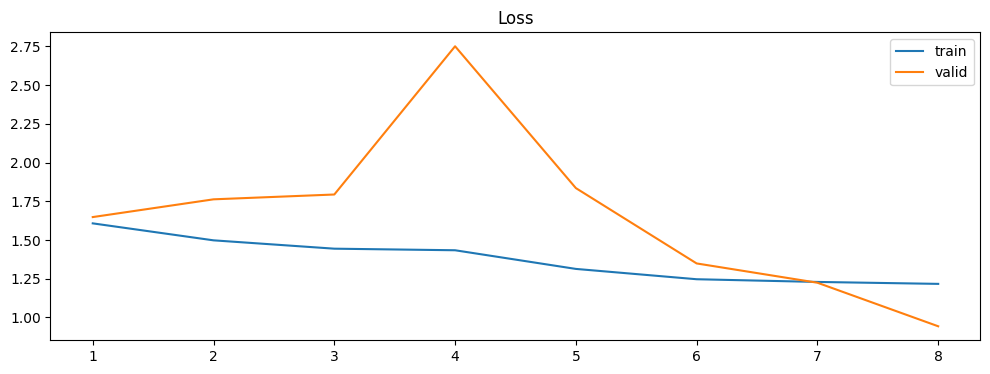

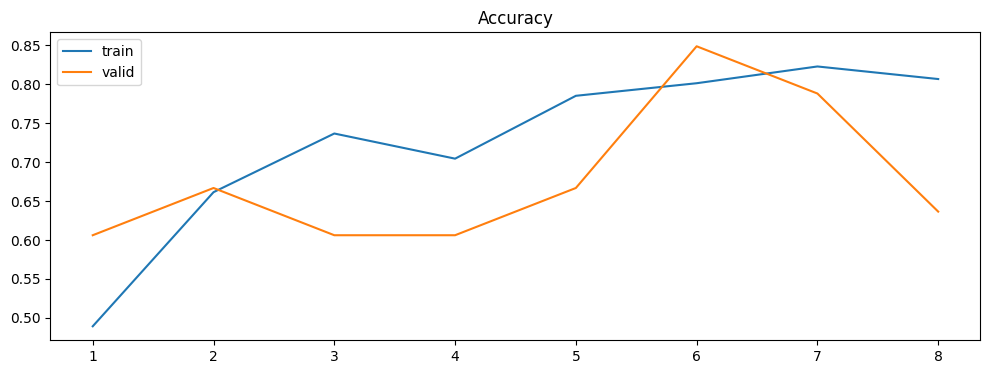

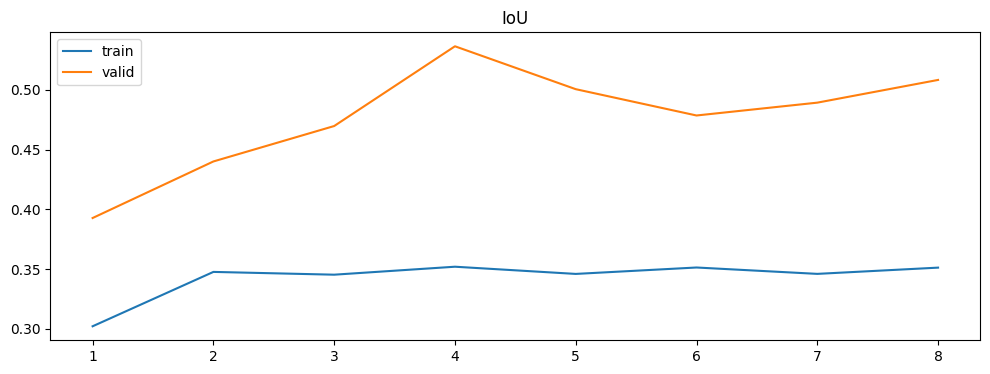

Targets [0,1] min/max/mean: (0.0, 0.99609375, 0.4807678461074829)
Preds   [0,1] min/max/mean: (0.16993612051010132, 0.8431165218353271, 0.47051239013671875)
IoU mean (batch): 0.44767932270042365


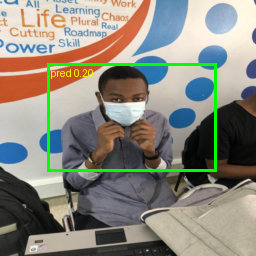

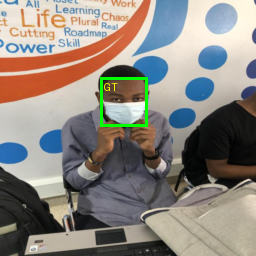

File: IMG_7309_JPG_jpg.rf.a0d52fd98d6d55b26272bf138a6c7068.jpg
IoU(pred,GT): 0.1246446818113327


In [ ]:
# Custom backbone
cfg = TrainConfig(
    backbone_type="custom",
    img_size=256,
    batch_size=32,
    lr=8e-4,
    weight_decay=1e-4,
    epochs=15,
    aug_strength="medium",
    use_albu=True,
    box_loss_w=2.0,
    beta_smoothl1=1.0,
)
tr = Trainer(df, cfg)
hist = tr.fit()
plot_history(hist)
sanity_check_batch(tr)
inference_example("best_custom.pt")

## 13) Transfer Learning — ResNet18

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s]


Epoch 001 | LR 2.37e-04 | TR loss 1.8341 acc 0.457 IoU 0.289 | VL loss 1.7073 acc 0.636 IoU 0.479 | MON(val_iou,max)=0.4786
Epoch 002 | LR 2.30e-04 | TR loss 1.6669 acc 0.720 IoU 0.320 | VL loss 1.4702 acc 0.970 IoU 0.436 | MON(val_iou,max)=0.4356
[FT] Backbone descongelado para fine-tuning.
Epoch 003 | LR 2.17e-04 | TR loss 1.3268 acc 0.919 IoU 0.340 | VL loss 0.7668 acc 1.000 IoU 0.484 | MON(val_iou,max)=0.4844
Epoch 004 | LR 2.00e-04 | TR loss 0.9761 acc 0.989 IoU 0.377 | VL loss 0.6926 acc 1.000 IoU 0.490 | MON(val_iou,max)=0.4901
Epoch 005 | LR 1.80e-04 | TR loss 0.8773 acc 0.989 IoU 0.391 | VL loss 0.6396 acc 0.970 IoU 0.556 | MON(val_iou,max)=0.5555
Epoch 006 | LR 1.57e-04 | TR loss 0.8765 acc 0.984 IoU 0.403 | VL loss 0.8206 acc 0.970 IoU 0.481 | MON(val_iou,max)=0.4813
Epoch 007 | LR 1.33e-04 | TR loss 0.8172 acc 0.995 IoU 0.406 | VL loss 0.5447 acc 1.000 IoU 0.599 | MON(val_iou,max)=0.5995
Epoch 008 | LR 1.07e-04 | TR loss 0.7778 acc 1.000 IoU 0.428 | VL loss 0.6139 acc 1.000

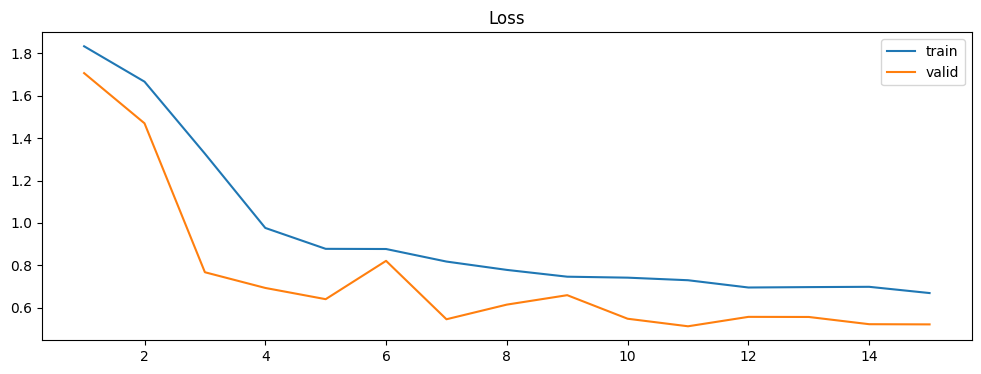

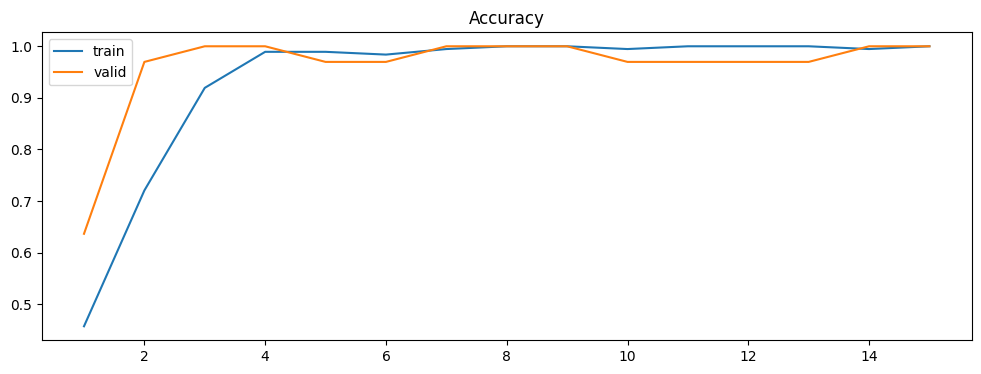

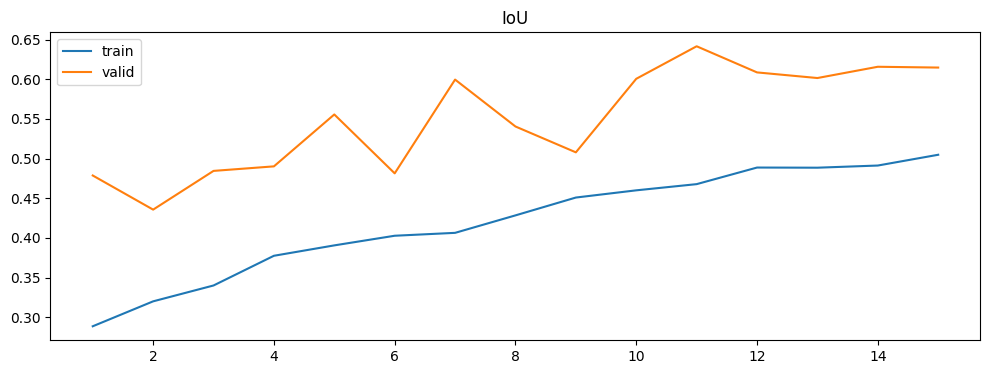

Targets [0,1] min/max/mean: (0.0, 0.99609375, 0.4807678461074829)
Preds   [0,1] min/max/mean: (0.0061116814613342285, 0.916260838508606, 0.4815826416015625)
IoU mean (batch): 0.6094623801764101


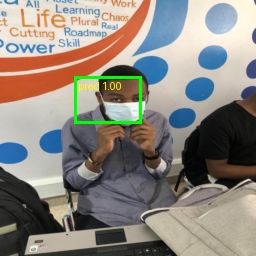

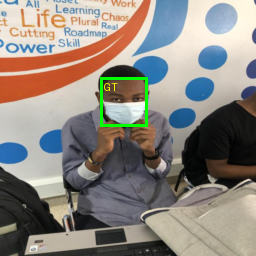

File: IMG_7309_JPG_jpg.rf.a0d52fd98d6d55b26272bf138a6c7068.jpg
IoU(pred,GT): 0.5267168283462524


In [ ]:
# --- Config ---
cfg_r18 = TrainConfig(
    backbone_type="resnet18",
    img_size=256,
    batch_size=32,
    lr=8e-4,
    weight_decay=1e-4,
    epochs=15,
    es_patience=5,
    freeze_backbone_epochs=3,  # ← 3 en lugar de 2
    aug_strength="medium",
    use_albu=True,
    box_loss_w=2.5,
    beta_smoothl1=1.0,
    monitor="val_iou",
    monitor_mode="max",
)

tr_r18 = Trainer(df, cfg_r18)

# --- OPT con param groups (backbone más lento) ---
backbone_params = list(tr_r18.model.backbone.parameters())
head_params = list(tr_r18.model.cls_head.parameters()) + list(
    tr_r18.model.box_head.parameters()
)

tr_r18.opt = torch.optim.AdamW(
    [
        {
            "params": backbone_params,
            "lr": cfg_r18.lr * 0.3,
        },  # ← LR 3x menor para backbone
        {"params": head_params, "lr": cfg_r18.lr},
    ],
    weight_decay=cfg_r18.weight_decay,
)
tr_r18.sched = torch.optim.lr_scheduler.CosineAnnealingLR(
    tr_r18.opt, T_max=cfg_r18.epochs
)

hist_r18 = tr_r18.fit()
plot_history(hist_r18)
sanity_check_batch(tr_r18)
inference_example("best_resnet18.pt")

['best_iou_resnet18.pt', 'best_resnet18.pt']
Epoch 001 | LR 9.05e-05 | TR loss 0.8885 acc 1.000 IoU 0.456 | VL loss 0.6246 acc 0.970 IoU 0.619 | MON(val_iou,max)=0.6194
Epoch 002 | LR 6.55e-05 | TR loss 0.9030 acc 0.995 IoU 0.454 | VL loss 0.5570 acc 1.000 IoU 0.652 | MON(val_iou,max)=0.6521
Epoch 003 | LR 3.45e-05 | TR loss 0.8239 acc 1.000 IoU 0.494 | VL loss 0.5659 acc 1.000 IoU 0.644 | MON(val_iou,max)=0.6443
Epoch 004 | LR 9.55e-06 | TR loss 0.7979 acc 1.000 IoU 0.509 | VL loss 0.4715 acc 1.000 IoU 0.703 | MON(val_iou,max)=0.7025
Epoch 005 | LR 0.00e+00 | TR loss 0.7963 acc 1.000 IoU 0.509 | VL loss 0.4801 acc 1.000 IoU 0.697 | MON(val_iou,max)=0.6966


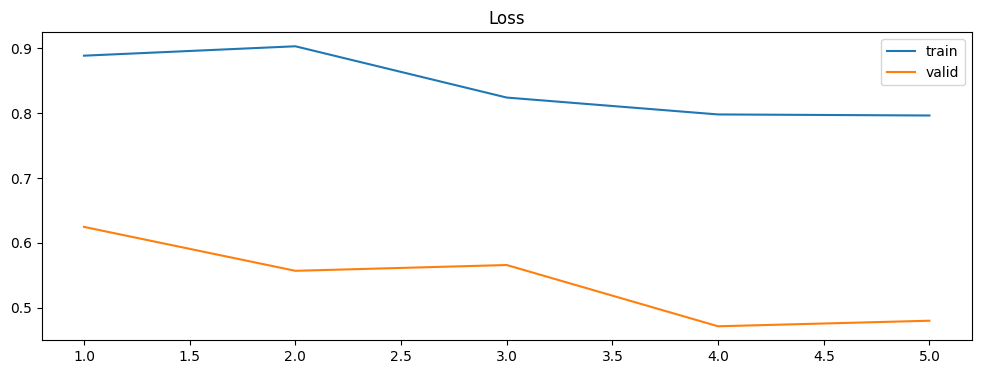

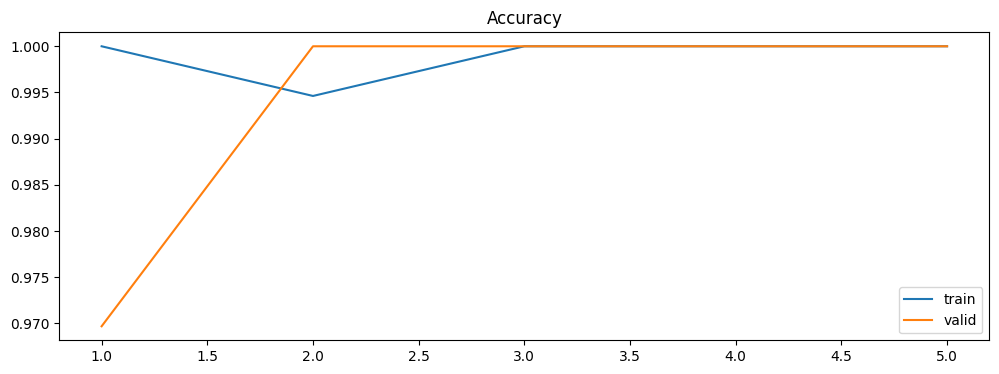

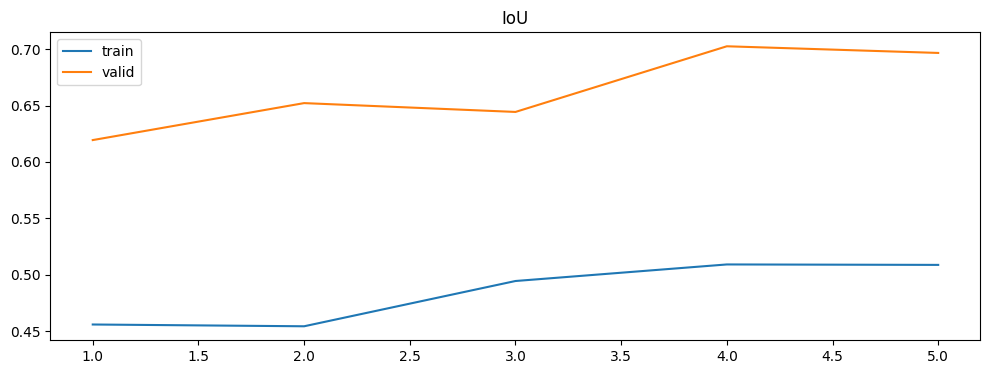

Targets [0,1] min/max/mean: (0.0, 0.99609375, 0.4807678461074829)
Preds   [0,1] min/max/mean: (0.0, 0.9755806922912598, 0.4811306297779083)
IoU mean (batch): 0.6054147952236235


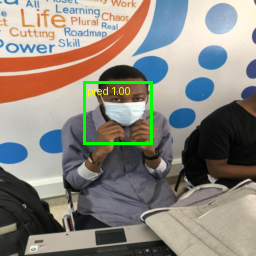

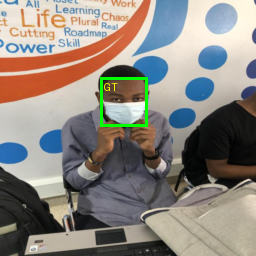

File: IMG_7309_JPG_jpg.rf.a0d52fd98d6d55b26272bf138a6c7068.jpg
IoU(pred,GT): 0.46005895733833313


In [ ]:
# === Micro Fine-Tune con DIoU (3–5 épocas) ===
from pathlib import Path

print([p.name for p in Path(".").glob("best*_resnet18.pt")])  # verifica nombres
ckpt_path = "best_iou_resnet18.pt"  # o el que mejor IoU te dio a 256

cfg_ft = TrainConfig(
    backbone_type="resnet18",
    img_size=256,
    batch_size=32,
    lr=5e-4,
    weight_decay=1e-4,
    epochs=5,
    es_patience=3,
    freeze_backbone_epochs=0,  # ya finetune
    aug_strength="light",
    use_albu=True,
    box_loss_w=3.0,
    beta_smoothl1=0.7,  # más foco en caja
    monitor="val_iou",
    monitor_mode="max",
)

tr_ft = Trainer(df, cfg_ft)

# Carga pesos previos
ckpt = torch.load(ckpt_path, map_location=DEVICE)
tr_ft.model.load_state_dict(ckpt["model_state"])

# Param groups conservadores: backbone más lento
backbone_params = list(tr_ft.model.backbone.parameters())
head_params = list(tr_ft.model.cls_head.parameters()) + list(
    tr_ft.model.box_head.parameters()
)
tr_ft.opt = torch.optim.AdamW(
    [
        {"params": backbone_params, "lr": cfg_ft.lr * 0.2},
        {"params": head_params, "lr": cfg_ft.lr},
    ],
    weight_decay=cfg_ft.weight_decay,
)
tr_ft.sched = torch.optim.lr_scheduler.CosineAnnealingLR(tr_ft.opt, T_max=cfg_ft.epochs)

hist_ft = tr_ft.fit()
plot_history(hist_ft)
sanity_check_batch(tr_ft)
inference_example("best_resnet18.pt")

1) Congelar el mejor checkpoint (renombrar y exportar)

In [24]:
# 1) Elige el "mejor" por IoU (debería ser best_resnet18.pt si monitor='val_iou')
from pathlib import Path
print([p.name for p in Path('.').glob('best*_resnet18.pt')])

src_ckpt = "best_resnet18.pt"         # ajusta si fuese "best_iou_resnet18.pt"
final_ckpt = "resnet18_diou_final.pt"

import shutil, torch
shutil.copy2(src_ckpt, final_ckpt)
print("Guardado final:", final_ckpt)

# 2) Exportar a TorchScript y ONNX (tamaño fijo 256)
ckpt = torch.load(final_ckpt, map_location=DEVICE)
cfgd = ckpt['cfg']

# reconstruir el modelo con la misma config, using ONNX-compatible backbone
if cfgd['backbone_type'] == 'resnet18':
    backbone = make_resnet18_backbone_onnx(img_size=cfgd['img_size'], feat_dim=cfgd['feat_dim'], pretrained=False) # Use ONNX-compatible backbone
else:
    raise RuntimeError("Esperábamos resnet18 en el final.")
model = TwoHeadNet(backbone, feat_dim=cfgd['feat_dim'], dropout=cfgd['dropout']).to('cpu')
model.load_state_dict(ckpt['model_state'])
model.eval()

example = torch.randn(1,3,cfgd['img_size'],cfgd['img_size'])
ts = torch.jit.trace(model, example)
ts.save("resnet18_diou_final.ts.pt")
print("TorchScript:", "resnet18_diou_final.ts.pt")

!pip install onnx # Add ONNX installation

torch.onnx.export(model, example, "resnet18_diou_final.onnx",
                  input_names=['input'], output_names=['logits','box01'],
                  opset_version=11)
print("ONNX:", "resnet18_diou_final.onnx")

['best_iou_resnet18.pt', 'best_resnet18.pt']
Guardado final: resnet18_diou_final.pt
TorchScript: resnet18_diou_final.ts.pt
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 123.9 MB/s eta 0:00:00


/tmp/ipython-input-3330445055.py:32: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model, example, "resnet18_diou_final.onnx",


ONNX: resnet18_diou_final.onnx


2) Calibrar el umbral de clasificación (opcional pero útil)

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score


@torch.no_grad()
def collect_valid_preds(trainer):
    probs_all, y_all = [], []
    for imgs, _, t_cls, _ in trainer.dl_valid:
        imgs = imgs.to(DEVICE)
        logits, _ = trainer.model(imgs)
        probs = torch.sigmoid(logits).cpu().numpy()
        probs_all.append(probs)
        y_all.append(t_cls.squeeze(1).cpu().numpy())
    return np.concatenate(probs_all), np.concatenate(y_all)


# usa el trainer con el que validaste el checkpoint final (por ej., tr_ft)
probs, y_true = collect_valid_preds(tr_ft)
best_thr, best_f1, best_acc = 0.5, -1, -1
for thr in np.linspace(0.3, 0.7, 21):
    y_pred = (probs >= thr).astype(np.int32)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    if f1 > best_f1:
        best_f1, best_acc, best_thr = f1, acc, thr
print(f"Mejor threshold≈ {best_thr:.2f} | F1={best_f1:.3f} | ACC={best_acc:.3f}")

Mejor threshold≈ 0.30 | F1=1.000 | ACC=1.000


3) Métricas finales en valid (accuracy / AUROC / IoU)

In [ ]:
from torchmetrics.classification import BinaryAUROC


@torch.no_grad()
def evaluate_full(trainer):
    acc = BinaryAccuracy().to(DEVICE)
    auroc = BinaryAUROC().to(DEVICE)
    ious = []
    for imgs, t_boxes01, t_cls, _ in trainer.dl_valid:
        imgs = imgs.to(DEVICE)
        t_boxes01 = t_boxes01.to(DEVICE)
        t_flat = t_cls.squeeze(1).to(DEVICE)
        logits, p_box01 = trainer.model(imgs)
        probs = torch.sigmoid(logits)
        acc.update(probs, t_flat)
        try:
            auroc.update(probs, t_flat.int())
        except:
            pass
        sz = float(trainer.cfg.img_size)
        pred_px = p_box01 * sz
        tgt_px = t_boxes01 * sz
        for i in range(len(pred_px)):
            ious.append(float(iou(pred_px[i], tgt_px[i]).item()))
    return (
        float(acc.compute().item()),
        float(auroc.compute().item()),
        float(np.mean(ious)),
    )


acc_f, auroc_f, miou_f = evaluate_full(tr_ft)  # o tr_r18 del run ganador
print(f"ACC={acc_f:.3f} | AUROC={auroc_f:.3f} | mIoU={miou_f:.3f}")

ACC=1.000 | AUROC=1.000 | mIoU=0.611


4) Visualizar casos difíciles (análisis de error rápido)

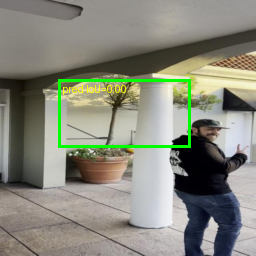

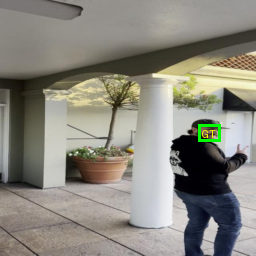

file: IMG_4860_mp4-4_jpg.rf.4ebe7129b4b9ebff2910ba3953e16a6b.jpg


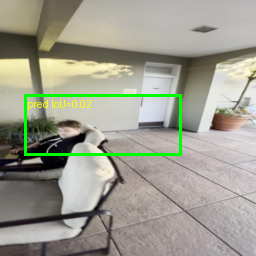

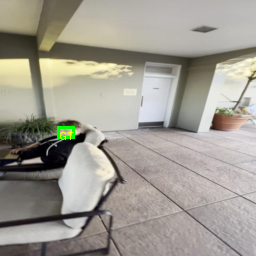

file: IMG_4860_mp4-15_jpg.rf.dfe85d8f89df182be5d9f0d27ac36892.jpg


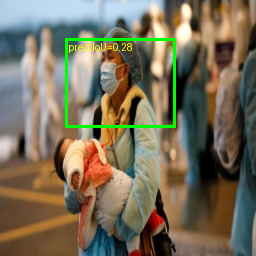

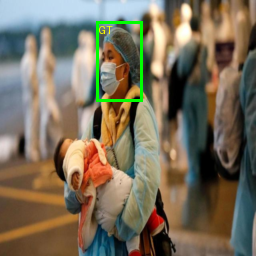

file: 000_1ov3n5_0_jpeg_jpg.rf.1377032a94440888773ef9dcb4e3101c.jpg


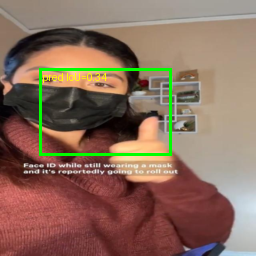

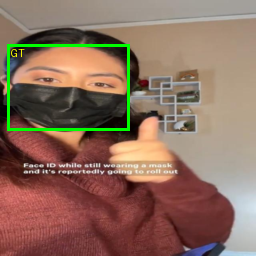

file: Apple-Tests-Face-ID-Feature-While-Wearing-a-Mask-Shorts_mp4-15_jpg.rf.cac02e1fce654f3b73c2d8375235d48c.jpg


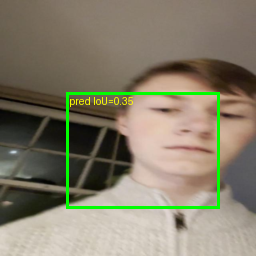

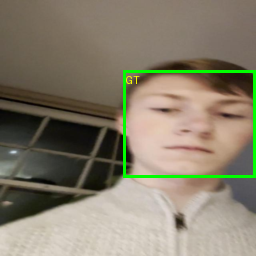

file: IMG_1493_mp4-43_jpg.rf.a1d5cddef485ef3ee6310488a5ec3ba4.jpg


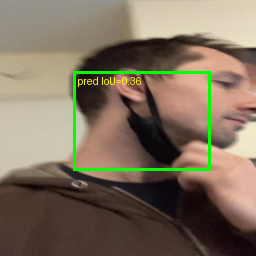

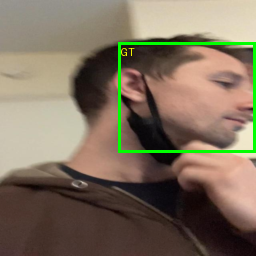

file: IMG_3094_mp4-37_jpg.rf.fe960ea463ee04ef3b75cb57bbd9f9bf.jpg


In [ ]:
@torch.no_grad()
def worst_k_examples(trainer, k=6):
    rec = []
    for imgs, t_boxes01, t_cls, fnames in trainer.dl_valid:
        imgs = imgs.to(DEVICE)
        t_boxes01 = t_boxes01.to(DEVICE)
        logits, p_box01 = trainer.model(imgs)
        sz = float(trainer.cfg.img_size)
        pred_px = p_box01 * sz
        tgt_px = t_boxes01 * sz
        for i in range(len(imgs)):
            rec.append(
                (
                    iou(pred_px[i], tgt_px[i]).item(),
                    imgs[i].cpu(),
                    pred_px[i].cpu(),
                    tgt_px[i].cpu(),
                    fnames[i],
                )
            )
    rec.sort(key=lambda x: x[0])
    return rec[:k]


bad = worst_k_examples(tr_ft, k=6)
for sc, img_t, pb, tb, fn in bad:
    im = denorm(img_t)
    im_pred = draw_box(im.copy(), pb, f"pred IoU={sc:.2f}")
    im_gt = draw_box(im.copy(), tb, "GT")
    display(im_pred, im_gt)
    print("file:", fn)

In [ ]:
# === SUBMISSION (alineado al sample: filename,class,xmin,ymin,xmax,ymax) ===
import os, numpy as np, pandas as pd, torch
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast

# ------------ Config mínima ------------
BASE = Path("./data_mask")  # carpeta raíz del dataset
# Usa tu checkpoint final (ajústalo si tu mejor archivo se llama distinto)
CKPT_CANDIDATES = ["resnet18_diou_final.pt", "best_resnet18.pt", "best_iou_resnet18.pt"]
CKPT_PATH = next((p for p in CKPT_CANDIDATES if Path(p).exists()), None)
assert CKPT_PATH is not None, "No encontré el checkpoint final. Ajusta CKPT_CANDIDATES."

# Umbral de clase: usa el calibrado si existe, si no 0.50
THR = globals().get("best_thr", 0.50)

# Etiquetas EXACTAS que pide la competición
LABEL_FOR_1 = "mask"
LABEL_FOR_0 = "no-mask"


# ------------ Localiza sample y test ------------
def find_first(paths):
    for p in paths:
        p = Path(p)
        if p.exists():
            return p
    return None


SAMPLE_SUB = find_first(
    [
        BASE / "sample_submission.csv",
        "data_mask/sample_submission.csv",
        "sample_submission.csv",
    ]
)
assert (
    SAMPLE_SUB is not None
), "No encontré sample_submission.csv. Ponlo en ./data_mask o en la raíz."

ss = pd.read_csv(SAMPLE_SUB)
assert "filename" in ss.columns, "El sample debe tener columna 'filename'."
wanted_fns = ss["filename"].tolist()
want_cols = list(ss.columns)

TEST_DIR = (
    find_first(
        [
            BASE / "test",
            BASE / "images/test",
            BASE / "test_images",
            BASE / "test_imgs",
            BASE / "imgs_test",
            BASE,
        ]
    )
    or BASE
)

# Mapea filename -> ruta real en TEST_DIR
img_exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
all_imgs = [p for p in TEST_DIR.rglob("*") if p.suffix.lower() in img_exts]
by_name = {p.name: p for p in all_imgs}
missing = [fn for fn in wanted_fns if fn not in by_name]
if missing:
    print(
        f"⚠️ WARNING: {len(missing)} archivos del sample no se encontraron en {TEST_DIR}. Ejemplos:",
        missing[:5],
    )

test_files = [by_name[fn] for fn in wanted_fns if fn in by_name]
print(f"TEST_DIR: {TEST_DIR} | imágenes usadas: {len(test_files)} de {len(wanted_fns)}")


# ------------ Dataset de inferencia ------------
class TestDataset(Dataset):
    def __init__(
        self, files, img_size, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    ):
        self.files = list(files)
        self.img_size = int(img_size)
        self.mean, self.std = mean, std

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        p = self.files[i]
        img = Image.open(p).convert("RGB")
        w0, h0 = img.size
        img_r = img.resize((self.img_size, self.img_size), Image.BILINEAR)
        x = torch.tensor(np.array(img_r)).permute(2, 0, 1).float() / 255.0
        mean = torch.tensor(self.mean)[:, None, None]
        std = torch.tensor(self.std)[:, None, None]
        x = (x - mean) / std
        return x, (w0, h0), p.name


# ------------ Reconstruye modelo desde checkpoint ------------
ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
cfgd = ckpt["cfg"]
IMG_SIZE = int(cfgd["img_size"])

# Usa las funciones/ clases ya definidas en tu notebook:
if cfgd["backbone_type"] == "resnet18":
    backbone = make_resnet18_backbone(feat_dim=cfgd["feat_dim"], pretrained=False)
elif cfgd["backbone_type"] == "mobilenetv3":
    backbone = make_mobilenet_v3_small_backbone(
        feat_dim=cfgd["feat_dim"], pretrained=False
    )
else:
    backbone = SimpleBackbone(base_ch=cfgd["base_ch"], feat_dim=cfgd["feat_dim"])

model = TwoHeadNet(backbone, feat_dim=cfgd["feat_dim"], dropout=cfgd["dropout"]).to(
    DEVICE
)
model.load_state_dict(ckpt["model_state"])
model.eval()


# ------------ Helper robusto (recuperar w,h por item del batch) ------------
def get_wh(orig_wh_batch, i):
    """
    Maneja:
    A) tensor [B,2]
    B) tuple/list (ws, hs) cada uno lista/tensor len=B
    C) lista de pares [(w,h), ...]
    """
    o = orig_wh_batch
    if torch.is_tensor(o):
        if o.ndim == 2 and o.shape[1] >= 2:
            return float(o[i, 0].item()), float(o[i, 1].item())
    if isinstance(o, (list, tuple)) and len(o) == 2:
        ws, hs = o
        if torch.is_tensor(ws):
            return float(ws[i].item()), float(hs[i].item())
        else:
            return float(ws[i]), float(hs[i])
    w, h = o[i]
    return float(w), float(h)


# ------------ Inferencia ------------
BATCH = 32
ds_test = TestDataset(test_files, img_size=IMG_SIZE)
dl_test = DataLoader(
    ds_test,
    batch_size=BATCH,
    shuffle=False,
    num_workers=2,
    pin_memory=(DEVICE == "cuda"),
)

rows = []
with torch.no_grad():
    for x, orig_wh, names in dl_test:
        x = x.to(DEVICE)
        with autocast(device_type="cuda", enabled=(DEVICE == "cuda")):
            logits, box01 = model(x)  # logits [B], box01 [B,4] en [0,1] xyxy
        probs = torch.sigmoid(logits).cpu().numpy()

        for i, name in enumerate(names):
            w0, h0 = get_wh(orig_wh, i)

            x1 = float(box01[i, 0].cpu().item() * w0)
            x1 = max(0.0, min(w0 - 1, x1))
            y1 = float(box01[i, 1].cpu().item() * h0)
            y1 = max(0.0, min(h0 - 1, y1))
            x2 = float(box01[i, 2].cpu().item() * w0)
            x2 = max(0.0, min(w0 - 1, x2))
            y2 = float(box01[i, 3].cpu().item() * h0)
            y2 = max(0.0, min(h0 - 1, y2))

            # asegurar orden válido
            x1, x2 = (x1, x2) if x1 <= x2 else (x2, x1)
            y1, y2 = (y1, y2) if y1 <= y2 else (y2, y1)

            label = LABEL_FOR_1 if probs[i] >= THR else LABEL_FOR_0

            rows.append(
                {
                    "filename": name,
                    "class": label,
                    "xmin": int(round(x1)),
                    "ymin": int(round(y1)),
                    "xmax": int(round(x2)),
                    "ymax": int(round(y2)),
                }
            )

sub = pd.DataFrame(rows)

# ------------ Alinear EXACTO al sample (filas + columnas + orden) ------------
# 1) Filtra a solo filenames del sample y en el MISMO orden
sub = sub.set_index("filename").reindex(ss["filename"]).reset_index()

# 2) Si hubo filenames del sample que no se hallaron, rellena con defaults seguros
if sub.isna().any(axis=1).sum() > 0:
    sub["class"] = sub["class"].fillna(LABEL_FOR_0)  # por defecto "no-mask"
    for c in ["xmin", "ymin", "xmax", "ymax"]:
        # caja mínima 1x1 en (0,0) si faltara algo
        sub[c] = sub[c].fillna(1 if c in ["xmax", "ymax"] else 0).astype(int)

# 3) Asegura columnas EXACTAS del sample y orden
sub = sub[want_cols]

# 4) Guardar
SUB_PATH = "submission.csv"
sub.to_csv(SUB_PATH, index=False)
print("✅ Submission guardada en:", SUB_PATH)
print(sub.head())
print("Filas:", len(sub), "| Columnas:", list(sub.columns))

TEST_DIR: data_mask | imágenes usadas: 55 de 55
✅ Submission guardada en: submission.csv
                                            filename    class  xmin  ymin  \
0  012106_jpg_1140x855_jpg.rf.b784fe385fa3967de70...     mask   191   124   
1  1303078448-China-Coronavirus-Death-Toll-Hits-3...     mask   200   107   
2  Apple-Tests-Face-ID-Feature-While-Wearing-a-Ma...     mask   149   163   
3  Apple-Tests-Face-ID-Feature-While-Wearing-a-Ma...  no-mask   152   148   
4  Apple-Tests-Face-ID-Feature-While-Wearing-a-Ma...  no-mask   139   170   

   xmax  ymax  
0   468   401  
1   448   321  
2   433   390  
3   433   362  
4   466   417  
Filas: 55 | Columnas: ['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
